In [108]:
# Read loan data from lending club

import pandas as pd
loan_data = pd.read_csv('lc_2015_loans.csv')


C:\Users\mohan\Anaconda3\envs\cryptocurrency-analysis\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sec_app_open_il_6m,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,age_earliest_cr,loan_to_income,il_util_ex_mort,installment_pct_inc,adjusted_dti
0,66624733,NaN,18000,18000,18000.0,60 months,19.48,471.70,E,E2,...,NaN,NaN,NaN,NaN,NaN,4472.0,0.120000,1.157349,0.037736,0.361647
1,68367011,NaN,21000,21000,21000.0,60 months,13.99,488.53,C,C4,...,NaN,NaN,NaN,NaN,NaN,4623.0,0.403846,1.073043,0.112738,7.565519
2,68615044,NaN,16000,16000,16000.0,60 months,13.99,372.21,C,C4,...,NaN,NaN,NaN,NaN,NaN,4715.0,0.112676,0.903690,0.031454,4.812486
3,68476697,NaN,15700,15700,15700.0,60 months,16.59,386.74,D,D2,...,NaN,NaN,NaN,NaN,NaN,4319.0,0.327083,1.032641,0.096685,5.952438
4,68516838,NaN,23850,23850,23850.0,60 months,17.27,596.21,D,D3,...,NaN,NaN,NaN,NaN,NaN,8763.0,0.350498,3.234950,0.105142,8.068733


In [110]:
# Check NaN columns
loan_data.isnull().sum()

id                                          0
member_id                              139021
loan_amnt                                   0
funded_amnt                                 0
funded_amnt_inv                             0
term                                        0
int_rate                                    0
installment                                 0
grade                                       0
sub_grade                                   0
emp_title                                8499
emp_length                               8470
home_ownership                              0
annual_inc                                  0
verification_status                         0
issue_d                                     0
loan_status                                 0
pymnt_plan                                  0
url                                         0
desc                                   139013
purpose                                     0
title                             

In [111]:
def removeNulls(dataframe, axis =1, percent=0.3):
    '''
    * removeNull function will remove the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 defines drop rows, axis =1(default) defines drop columns    
    * percent   : percent of data where column/rows values are null,default is 0.3(30%)
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

In [112]:
loan_data = removeNulls(loan_data, axis =1,percent = 0.3)

Number of Columns dropped	:  16

Old dataset rows,columns (139021, 133) 
New dataset rows,columns (139021, 117)


In [113]:
loan_data = removeNulls(loan_data, axis =0,percent = 0.3)


Number of Rows dropped	:  0

Old dataset rows,columns (139021, 117) 
New dataset rows,columns (139021, 117)


In [114]:
print(loan_data.shape)
print(list(loan_data.columns))

(139021, 117)
['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'ope

In [115]:
import numpy as np

import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import load_model

from keras.callbacks import ModelCheckpoint



APPLICANT_NUMERIC = ['annual_inc', 'dti', 'age_earliest_cr', 'loan_amnt', 'installment']

APPLICANT_CATEGORICAL = ['application_type', 'emp_length', 'home_ownership', 'addr_state', 'term']

CREDIT_NUMERIC = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
                  'bc_util', 'delinq_2yrs', 'delinq_amnt', 'fico_range_high', 'fico_range_low',
                  'last_fico_range_high', 'last_fico_range_low', 'open_acc', 'pub_rec', 'revol_util',
                  'revol_bal', 'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_rev_hi_lim',
                  'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
                  'num_bc_tl', 'num_il_tl', 'num_rev_tl_bal_gt_0', 'pct_tl_nvr_dlq',
                  'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
                  'total_il_high_credit_limit', 'all_util', 'loan_to_income',
                  'installment_pct_inc', 'il_util', 'il_util_ex_mort', 'total_bal_il', 'total_cu_tl']

LABEL = ['grade']

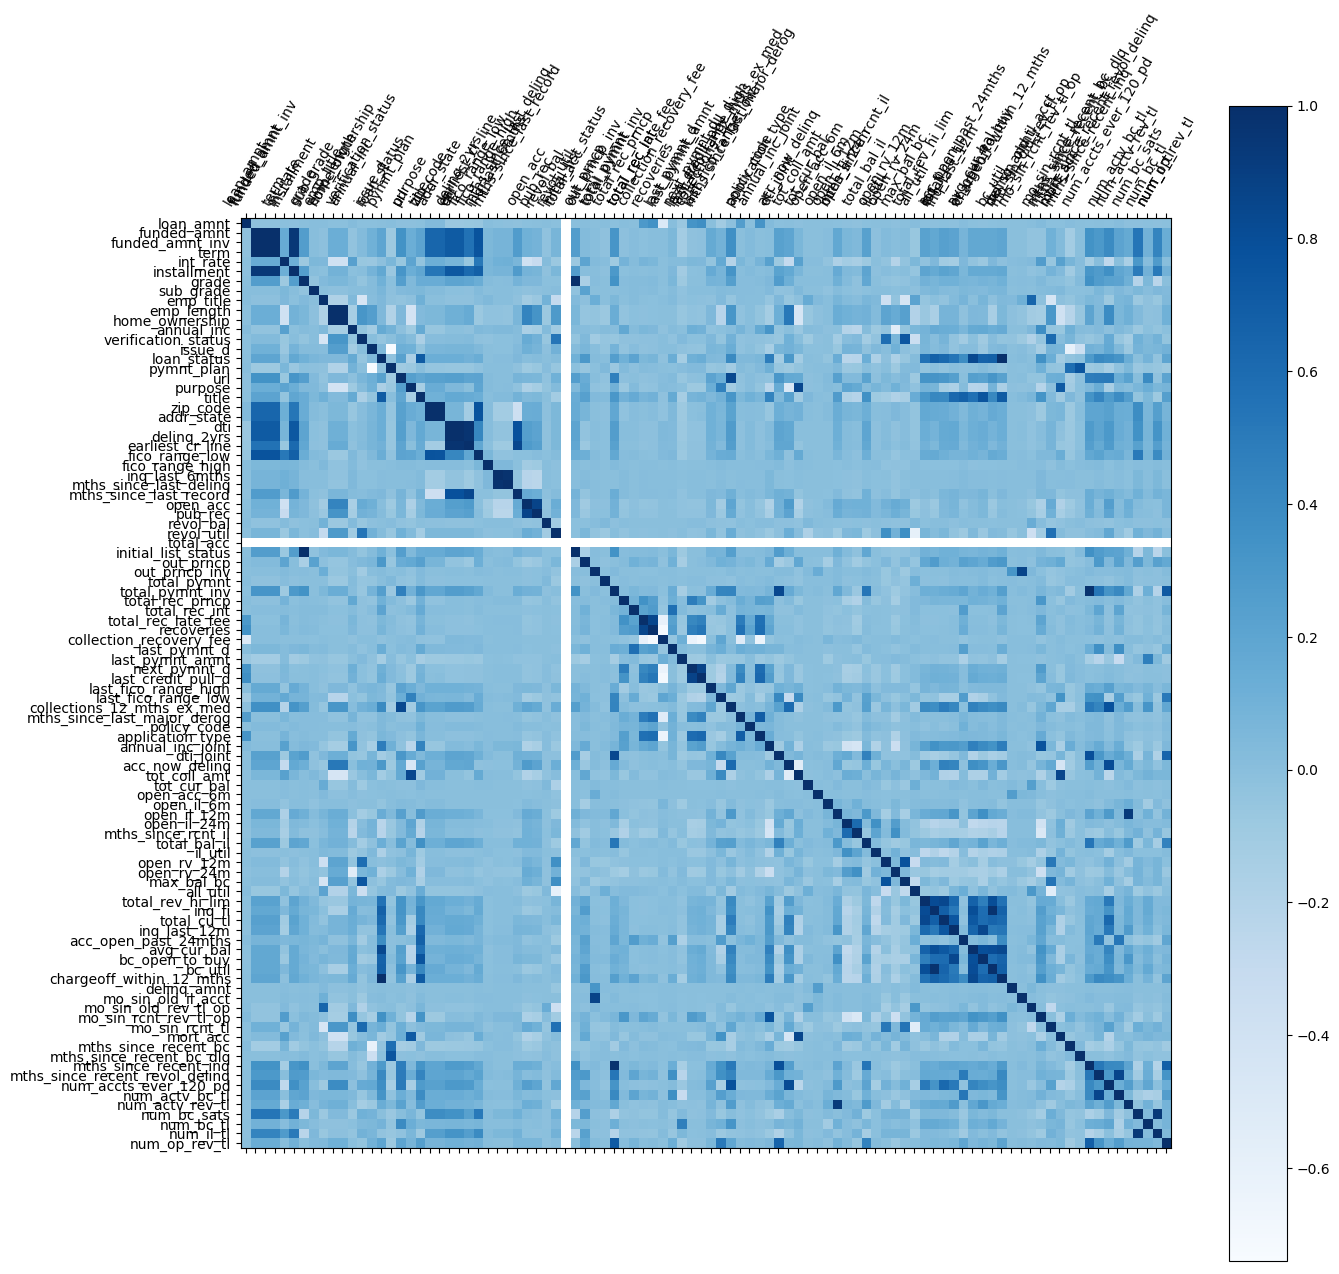

In [117]:
###"""Plots a correlation matrix of the data set"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

sns.reset_orig()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(loan_data.corr(), cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels(loan_data, rotation=60)
ax.set_yticklabels(loan_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.show()

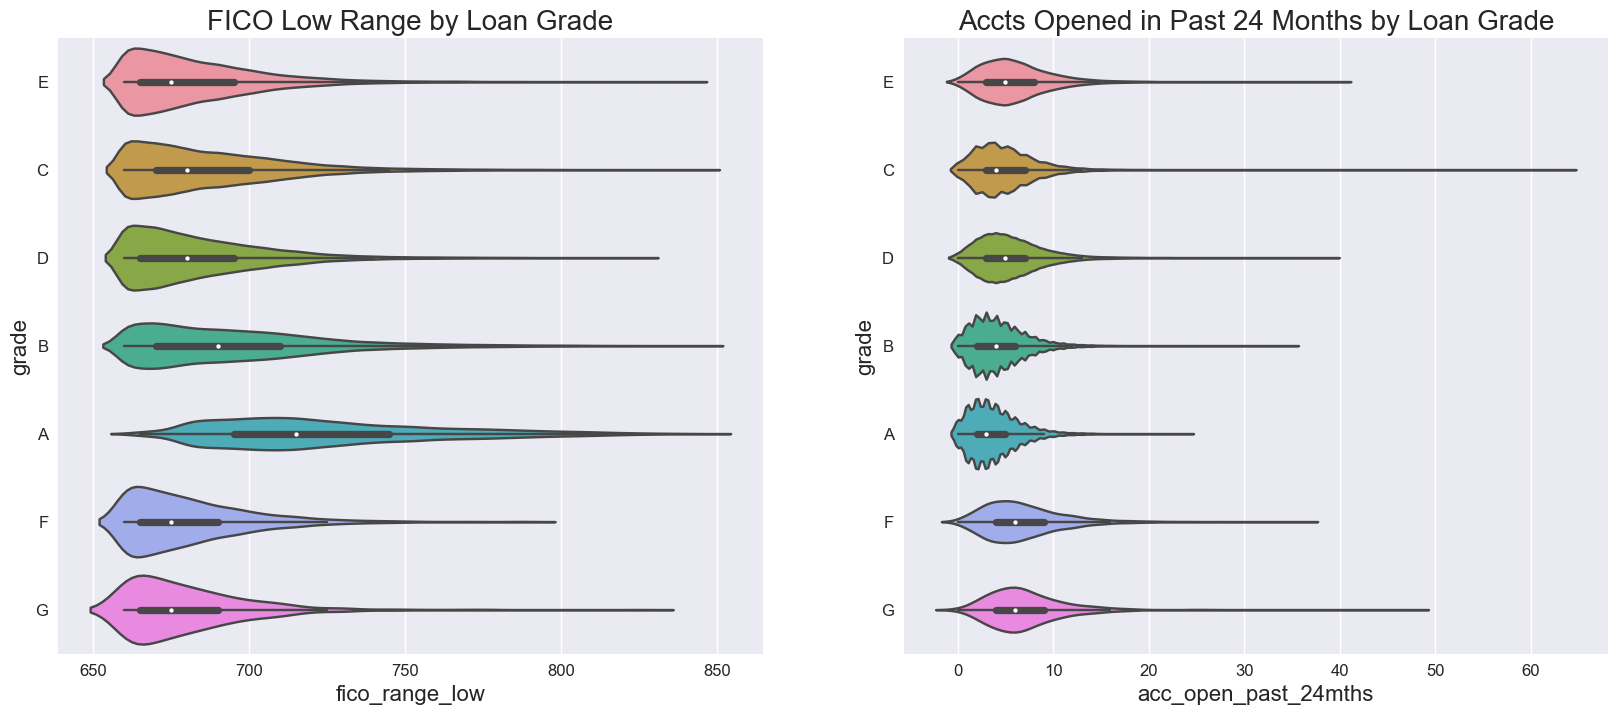

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

# Create violinplot
plt.subplot(121)
v1 = sns.violinplot(x = "fico_range_low", y="grade", data=loan_data)
v1.axes.set_title("FICO Low Range by Loan Grade", fontsize=20)

plt.subplot(122)
v2 = sns.violinplot(x = "acc_open_past_24mths", y="grade", data=loan_data)
v2.axes.set_title("Accts Opened in Past 24 Months by Loan Grade", fontsize=20)

# Show the plot
plt.show()

In [122]:
x_df = loan_data.loc[:, APPLICANT_NUMERIC +  CREDIT_NUMERIC + APPLICANT_CATEGORICAL+LABEL]
x_df.head()

,annual_inc,dti,age_earliest_cr,loan_amnt,installment,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,...,il_util,il_util_ex_mort,total_bal_il,total_cu_tl,application_type,emp_length,home_ownership,addr_state,term,grade
0,150000.0,9.39,4472.0,18000,471.70,0,7.0,2014.0,5128.0,51.3,...,71.00000,1.157349,22195.0,1.0,INDIVIDUAL,7 years,RENT,CA,60 months,E
1,52000.0,14.47,4623.0,21000,488.53,0,1.0,74481.0,2926.0,87.4,...,101.43377,1.073043,352033.0,0.0,INDIVIDUAL,< 1 year,RENT,OH,60 months,C
2,142000.0,17.74,4715.0,16000,372.21,0,7.0,47670.0,2827.0,44.6,...,69.00000,0.903690,109893.0,0.0,INDIVIDUAL,9 years,MORTGAGE,CA,60 months,C
3,48000.0,29.13,4319.0,15700,386.74,0,5.0,14211.0,1516.0,87.7,...,101.00000,1.032641,68316.0,2.0,INDIVIDUAL,6 years,MORTGAGE,LA,60 months,D
4,68046.0,24.71,8763.0,23850,596.21,0,0.0,47745.0,6.0,99.9,...,44.00000,3.234950,4453.0,0.0,INDIVIDUAL,10+ years,OWN,VA,60 months,D


In [119]:
import os
x_df = loan_data.loc[:, APPLICANT_NUMERIC +  CREDIT_NUMERIC + APPLICANT_CATEGORICAL]

### Take 1310 records as training and remaining 600 as test data
#Xtrain = pd.DataFrame(data[:600][feat_labels])
#Xtest = pd.DataFrame(data[42:][feat_labels])

#Ytrain = pd.DataFrame(data[:600]['XEM'])
#Ytest = pd.DataFrame(data[42:]['XEM'])
#APPLICANT_CATEGORICAL]
x_df.head()

# Update our X dataframe with categorical values replaced by one-hot encoded values

# """Replace categorical variables with one-hot encoding in-place"""
for col in APPLICANT_CATEGORICAL:
    # use get_dummies() to do one hot encoding of categorical column
    x_df = x_df.merge(pd.get_dummies(x_df[col]), left_index=True, right_index=True)
    # drop the original categorical column
    x_df.drop(col, axis=1, inplace=True)


row_limit = os.environ.get("sample")
test_size=0.2

# Ensure all numeric features are on the same scale
for col in APPLICANT_NUMERIC:
    x_df[col] = (x_df[col] - x_df[col].mean()) / x_df[col].std()

# Specify the target labels and flatten the array
y = pd.get_dummies(loan_data[LABEL])


# When requested, limit the amount of data that will be used
# Using entire data set can be painfully slow without a GPU!
if row_limit != None:
    rows = np.random.binomial(1, 0.1, size=len(loan_data)).astype('bool')
    x_df = x_df[rows]
    y = y[rows]
    print("Using only a sample of {} observations".format(x_df.shape[0]))
    data = loan_data.sample(int(row_limit))
else:
    print("Using the full set of {} observations".format(loan_data.shape[0]))

# Create train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=test_size, random_state=23)


# Inspect our training data
print("x_train contains {} rows and {} features".format(x_train.shape[0], x_train.shape[1]))
print("y_train contains {} rows and {} features".format(y_train.shape[0], y_train.shape[1]))

print("x_test contains {} rows and {} features".format(x_test.shape[0], x_test.shape[1]))
print("y_test contains {} rows and {} features".format(y_test.shape[0], y_test.shape[1]))

# Loan grade has been one-hot encoded
print("Sample one-hot encoded 'y' value: \n{}".format(y_train.sample()))

Using the full set of 139021 observations
x_train contains 111216 rows and 112 features
y_train contains 111216 rows and 7 features
x_test contains 27805 rows and 112 features
y_test contains 27805 rows and 7 features
Sample one-hot encoded 'y' value: 
        grade_A  grade_B  grade_C  grade_D  grade_E  grade_F  grade_G
117896        0        0        1        0        0        0        0


In [120]:
#"""Create Keras model"""

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm

def create_model(input_dim, output_dim):
    # create model
    model = Sequential()
    # input layer
    model.add(Dense(100, input_dim=input_dim, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # hidden layer
    model.add(Dense(60, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    
    # output layer
    model.add(Dense(output_dim, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [121]:
#        """Create and train the neural network model"""

# Create model using provided model function
from keras.callbacks import ModelCheckpoint

model = create_model(x_train.shape[1], y_train.shape[1])
gpu_enabled=True

# Model converges faster on larger data set with larger batches
epochs = 30 if gpu_enabled else 45

# GPU is actually *slower* than CPU when using small batch size
batch_sz = 1024 if gpu_enabled else 64

print("Beginning model training with batch size {} and {} epochs".format(batch_sz, epochs))

checkpoint = ModelCheckpoint("lc_model.h5", monitor='val_acc', verbose=0, save_best_only=True, mode='auto', period=1)

# train the model

history = model.fit(x_train.as_matrix(),y_train.as_matrix(),validation_split=0.33,epochs=epochs,  
                    batch_size=batch_sz, verbose=2,callbacks=[checkpoint])



Beginning model training with batch size 1024 and 30 epochs
Train on 74514 samples, validate on 36702 samples
Epoch 1/30
 - 2s - loss: 13.9365 - acc: 0.1353 - val_loss: nan - val_acc: 0.1752
Epoch 2/30
 - 1s - loss: 13.3137 - acc: 0.1740 - val_loss: nan - val_acc: 0.1751
Epoch 3/30
 - 1s - loss: 13.3437 - acc: 0.1721 - val_loss: nan - val_acc: 0.1750
Epoch 4/30
 - 1s - loss: 13.2741 - acc: 0.1765 - val_loss: nan - val_acc: 0.1750
Epoch 5/30
 - 1s - loss: 13.2739 - acc: 0.1765 - val_loss: nan - val_acc: 0.1750
Epoch 6/30
 - 1s - loss: 13.2710 - acc: 0.1766 - val_loss: nan - val_acc: 0.1750
Epoch 7/30
 - 1s - loss: 13.2719 - acc: 0.1766 - val_loss: nan - val_acc: 0.1750
Epoch 8/30
 - 1s - loss: 13.2710 - acc: 0.1766 - val_loss: nan - val_acc: 0.1750
Epoch 9/30
 - 1s - loss: 13.2739 - acc: 0.1765 - val_loss: nan - val_acc: 0.1750
Epoch 10/30
 - 1s - loss: 13.2706 - acc: 0.1767 - val_loss: nan - val_acc: 0.1750
Epoch 11/30
 - 1s - loss: 13.2710 - acc: 0.1766 - val_loss: nan - val_acc: 0.17

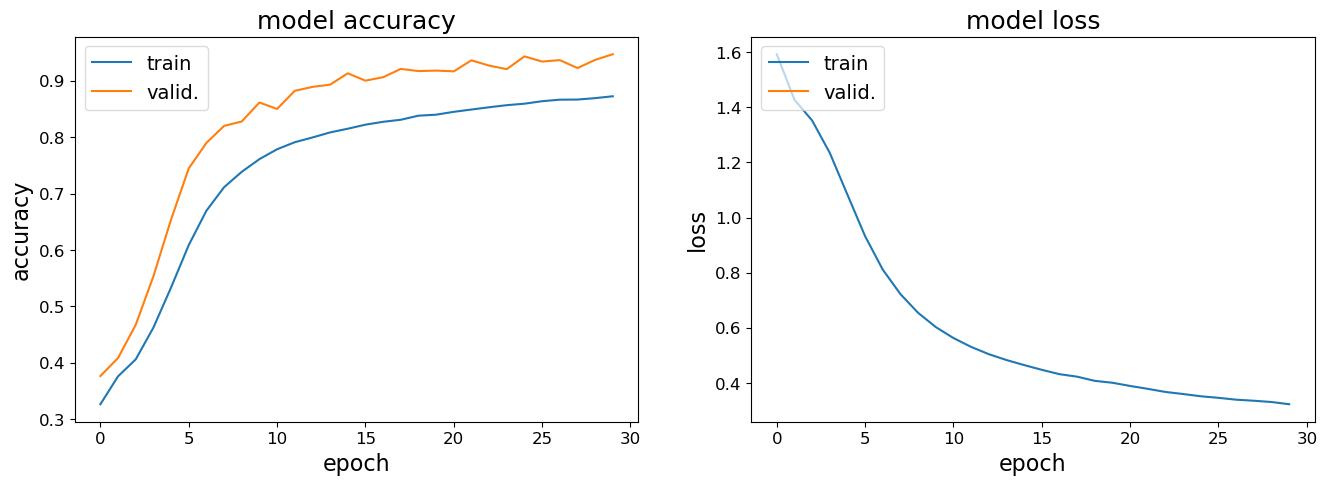

In [77]:
sns.reset_orig()

 #   """Plot accuracy and loss for a Keras history object"""

plt.rcParams["figure.figsize"] = [16, 5]
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['legend.framealpha'] = 0.7
plt.rcParams["legend.fontsize"] = 14

# Plot accuracy

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')


In [78]:
import numpy as np
from sklearn.metrics import f1_score

y_pred = model.predict(x_test.as_matrix())

# Revert one-hot encoding to classes
y_pred_classes = pd.DataFrame((y_pred.argmax(1)[:,None] == np.arange(y_pred.shape[1])),
                              columns=y_test.columns,
                              index=y_test.index)

y_test_vals = y_test.idxmax(1)
y_pred_vals = y_pred_classes.idxmax(1)

# F1 score
# Use idxmax() to convert back from one-hot encoding
f1 = f1_score(y_test_vals, y_pred_vals, average='weighted')
print("Test Set Accuracy: {:.2%}   (NOTE: Best results expected when training on the FULL dataset)".format(f1))


Test Set Accuracy: 94.72%   (NOTE: Best results expected when training on the FULL dataset)


In [79]:
def fmt_pct(x, pos):

    #"""Format as percentage"""

    return '{:.0%}'.format(x)

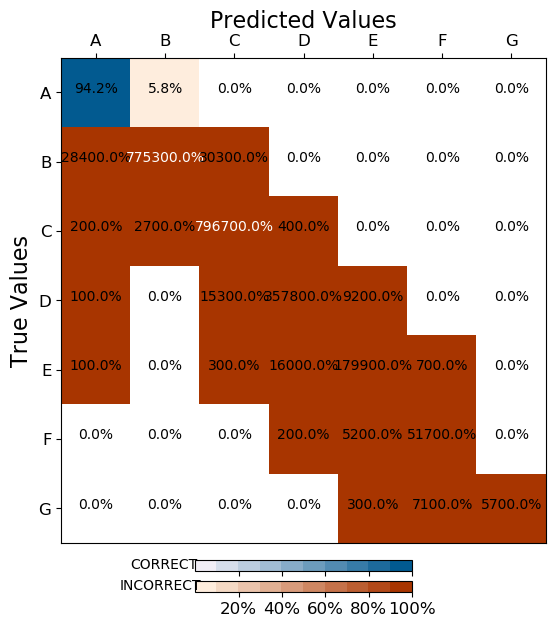

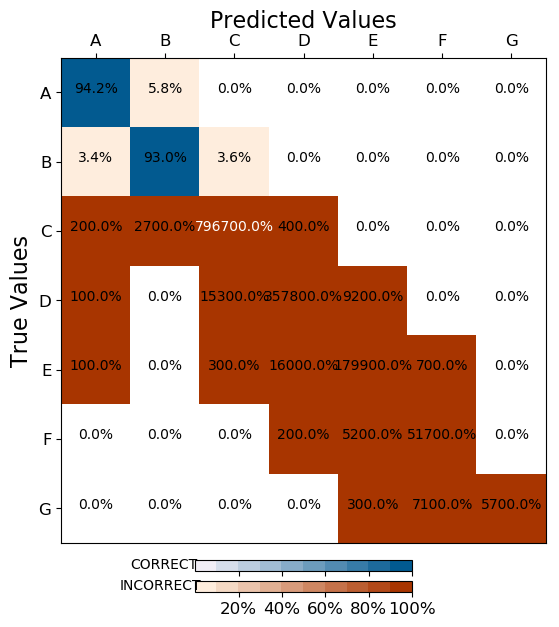

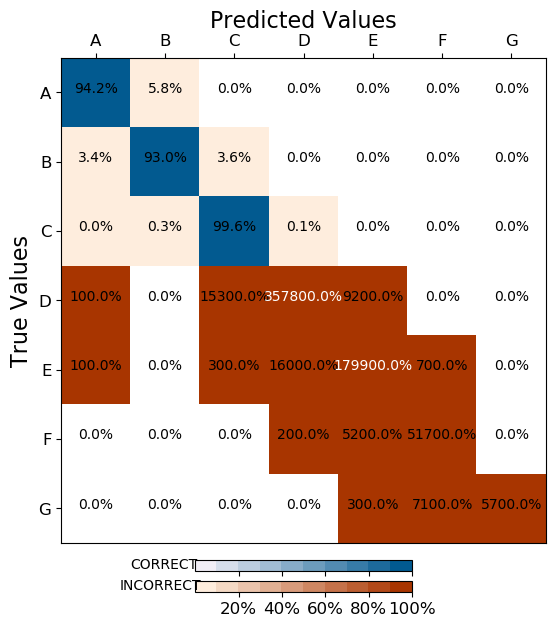

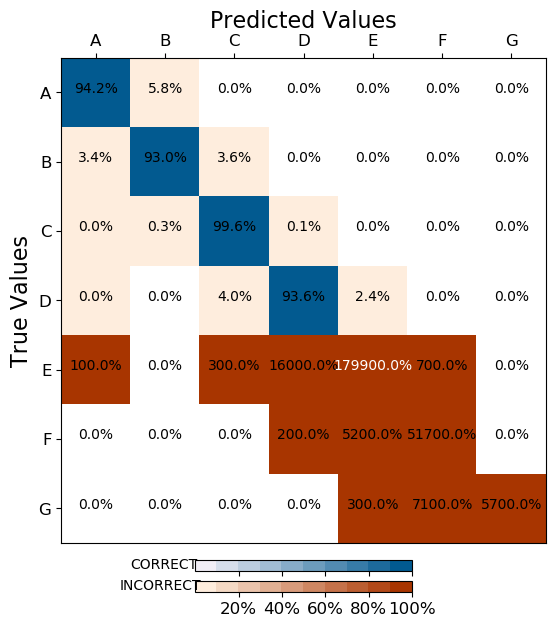

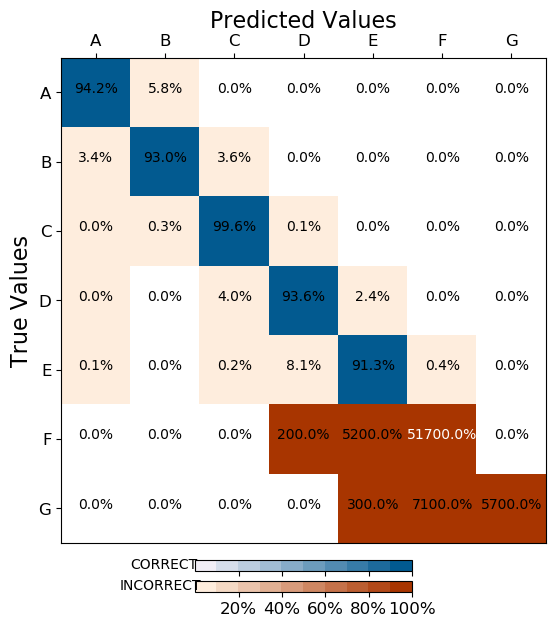

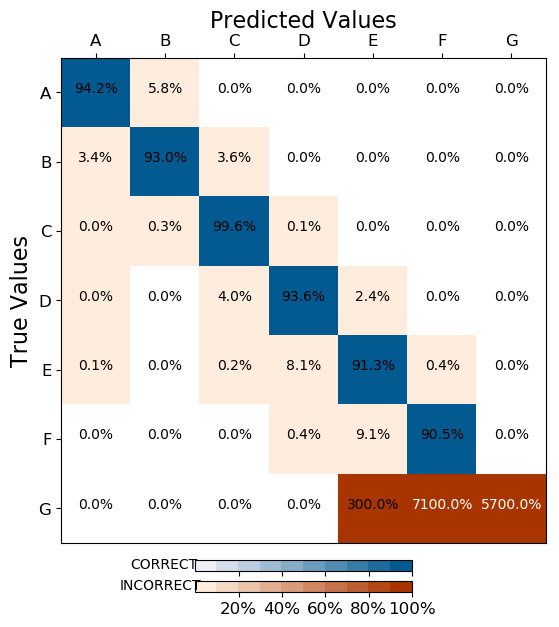

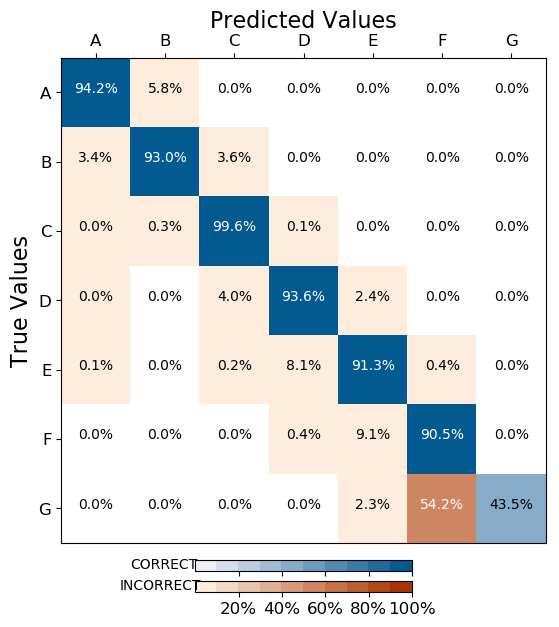

In [80]:
from sklearn.metrics import confusion_matrix
import itertools

# Confusion matrix
conf_matrix = confusion_matrix(y_test_vals, y_pred_vals).astype(float)

correct_mask = np.ones(conf_matrix.shape, dtype=bool)
wrong_mask = np.zeros(conf_matrix.shape, dtype=bool)

for i in range(conf_matrix.shape[0]):
    correct_mask[i,i] = False
    wrong_mask[i,i] = True
    row_sum = sum(conf_matrix[i])
    for j in range(conf_matrix.shape[1]):
         conf_matrix[i, j] = conf_matrix[i, j] / row_sum

    correct_matrix = np.ma.masked_array(conf_matrix, mask=correct_mask)
    wrong_matrix = np.ma.masked_array(conf_matrix, wrong_mask)

    fig,ax = plt.subplots(figsize=(8, 8))
    blue_map = colors.LinearSegmentedColormap.from_list('custom blue', ['#f1eef6', '#025a90'], N=10)
    blue_map.set_under(color='white')
    red_map = colors.LinearSegmentedColormap.from_list('custom blue', ['#feeddd', '#a83500'], N=10)
    red_map.set_under(color='white')
    plot_correct = ax.imshow(correct_matrix,interpolation='nearest',cmap=blue_map, vmin=0.000001, vmax=1)
    plot_wrong = ax.imshow(wrong_matrix,interpolation='nearest',cmap=red_map, vmin=0.000001, vmax=1)
    colorbar_wrong = plt.colorbar(plot_wrong, shrink=0.35, orientation='horizontal', pad=-0.11, format=ticker.FuncFormatter(fmt_pct))
    colorbar_correct = plt.colorbar(plot_correct, shrink=0.35, orientation='horizontal', pad=0.03)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xticklabels([''] + [l for l in "ABCDEFG"])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_yticklabels([''] + [l for l in "ABCDEFG"])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    colorbar_correct.ax.text(-0.3,0.25,'CORRECT',rotation=0)
    colorbar_wrong.ax.text(-0.35,0.25,'INCORRECT',rotation=0)
    plt.setp(colorbar_correct.ax.get_xticklabels(), visible=False)

    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
        cell_label = "{:.1%}".format(conf_matrix[i, j])
        plt.text(j, i, cell_label,
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")      
        